# Modelling Uncertainty with PyMC3

The vast majority of all Machine Learning (ML) models return a point-estimate of the most likely data label, given an instance of feature data. There are many scenarios where a point-estimate alone, is not enough - where we need to understand the uncertainty in the prediction. For example, when assessing risk, or more generally, when making decisions to optimise some cost (or utility) function. This need is particularly acute then the cost is a non-linear function of the variable you're trying to predict.

For these scenarios, 'traditional' statistical modelling can be invaluable. Half-way between statistics and ML we have probabilistic programming, rooted in the methods of Bayesian inference. This notebook demonstrates how to build a predictive model using [PyMC3](https://docs.pymc.io) - a Probabilistic Programming Language (PPL) for Python.

## A (very) Quick Introduction to Bayesian Data Analysis

Like statistical data analysis (and ML to some extent), the main aim of Bayesian Data Analysis (BDA) is to infer the unknown parameters in a model of observed data. For example, to test a hypotheses about the physical processes that lead to the observations. BDA deviates from traditional statistics - on a practical level - because it explicitly integrates prior knowledge regarding the uncertainty of the model parameters, into the statistical inference process. To this end, BDA focuses on the posterior distribution,

$$
p(\Theta | X) = \frac{p(X | \Theta) \cdot p(\Theta)}{p(X)}
$$

Where,

- $\Theta$ is the vector of unknown model parameters, that we wish to estimate; 
- $X$ is the vector of observed data;
- $p(X | \Theta)$ is the likelihood function that models the probability of observing the data for a fixed choice of parameters; and,
- $p(\Theta)$ is the prior distribution of the model parameters.

The unknown models parameters are not limited to regression coefficicnets - Deep Neural Networks (DNNs) can be trained using Bayesian inference and PPLs as an alternative to gradient descent, as demonstrated by [Thomas Wiecki](https://twiecki.io/blog/2016/06/01/bayesian-deep-learning/).

If you're interested in learning more, then an **excellent** (inspirational) and practical introduction is [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/). For a more theoretical treatment try [Bayesian Data Analysis by Gelman & co.](http://www.stat.columbia.edu/~gelman/book/). If you're curious, read on!

## Imports

In addition to PyMC3 we are also going to rely heavily on ArviZ, which is a inference data management and visualisation package that works with many PPLs, and is tightly coupled to PyMC3.

In [4]:
import warnings

import arviz as az
import joblib
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from numpy.random import binomial, randn, uniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

## Configuration

Set plot styles and suppress warning messages.

In [6]:
sns.set()
az.style.use("arviz-darkgrid")
warnings.filterwarnings("ignore")

## Create a Synthetic Dataset

To aid in building intuition for how Bayesian inference and PPLs work, we will simulate a 'toy' dataset using random number generation and then estimate the paramters.

For our synthetic dataset, we will assume that the dependent variable (or labelled data), $\tilde{y}$, is a linear function of a single independent variable (or feature), $x$, whose impact on $\tilde{y}$ depends on a categorical variable (or feature), $c$. We deinfine $x$ is a positive real number and $c$ to belong to one of two categories, that occur with equal likelihood. We express this model mathematically, as follows,

$$
\tilde{y} = \beta_{c} \cdot x + \sigma \cdot \tilde{\epsilon}
$$

where $\tilde{\epsilon} \sim N(0, 1)$, $\sigma$ is the standard deviation of the random noise in the data and $c \in \{0, 1\}$ denotes the category. We start by hard-coding our choices for the model parameters, that we will then try and estimate.

In [7]:
beta_c0 = 1
beta_c1 = 1.25

sigma = 0.75

Now we simulate 2,000 synthetic observations.

In [10]:
n_samples = 2000

category = binomial(n=1, p=0.5, size=n_samples)
x = uniform(low=0, high=10, size=n_samples)
y = ((1 - category) * beta_c0 + category * beta_c1) * x + sigma * randn(n_samples)

model_data = pd.DataFrame({"y": y, "x": x, "category": category})
display(model_data.head())

,y,x,category
0,9.819317,8.084579,1
1,4.627614,3.685698,1
2,4.202826,2.530517,1
3,8.185397,7.625491,0
4,10.520957,8.047588,1


And plot the full dataset, labelling each observation by the category assigned to it.

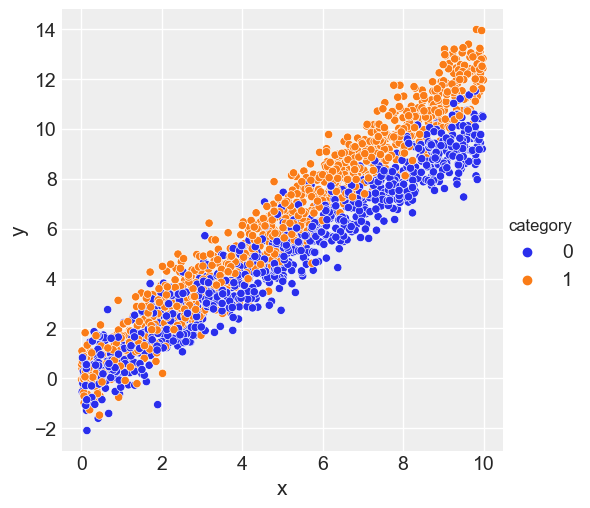

In [11]:
_ = sns.relplot(x="x", y="y", hue="category", data=model_data)

### Split Data into Training and Test Sets

One of the advantages of generating synthetic data is that we can ensure we have enough data to be able to partition it into two sets - one for training models and one for testing models. We use a helper function from the Scikit-Learn package for this task and make use of stratified sampling to ensure that we have a balanced representation of each category in both training and test datasets.

In [12]:
train, test = train_test_split(model_data, test_size=0.2, stratify=model_data.category)

## Define Model

Defining a Bayesian inference model in a PPL like PyMC3, has analagoues to defining a DNN model in a tensor computing framework like PyTorch. Perhaps this is not surprising, given that PyMC3 is built upon a tensor computing framework called [Aesara](https://github.com/pymc-devs/aesara). Aesara is a fork of [Theano](https://en.wikipedia.org/wiki/Theano_(software)), a precursor of TensorFlow, PyTorch, etc.

We start by defining the variables,

```python
with model:
    y = pm.Data("y", train["y"])
    x = pm.Data("x", train["x"])
    category = pm.Data("category", train["category"])
    
    # ...
```

And then the mathematical model that encodes our hypothesis about the real-world data-generating process. This is identical to the one used to generate the data,

```python
with model:
    # ...
    
    beta_prior = pm.Normal("beta", mu=0, sd=2, shape=2)
    sigma_prior = pm.HalfNormal("sigma", sd=2, shape=1)
    mu_likelihood = beta_prior[category] * x
    obs_likelihood = pm.Normal("obs", mu=mu_likelihood, sd=sigma_prior, observed=y)
 ```

Where we have made assumptions (or educated guesses) about the [prior distribution](https://en.wikipedia.org/wiki/Prior_probability) of all the parameters in the model. Although it is beyond the scope of this notebook, it is worth mentioning that it is possible to specify prior distribtions for the parameters within the prior distributions, referred to as hyper-priors. This setup is referred to as hierarchical modelling and can help defend against over-fitting to the training data, especially in the presence of high-cardinality categorical variables.

In [17]:
model = pm.Model()

with model:
    y = pm.Data("y", train["y"])
    x = pm.Data("x", train["x"])
    category = pm.Data("category", train["category"])

    beta_prior = pm.Normal("beta", mu=0, sd=2, shape=2)
    sigma_prior = pm.HalfNormal("sigma", sd=2, shape=1)
    mu_likelihood = beta_prior[category] * x
    obs_likelihood = pm.Normal("obs", mu=mu_likelihood, sd=sigma_prior, observed=y)

## Training the Model - the Bayesian Inference Step

TODO

In [18]:
with model:
    inference = pm.sample(draws=5000, tune=1000, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 34 seconds.


### Diagnostic Plots

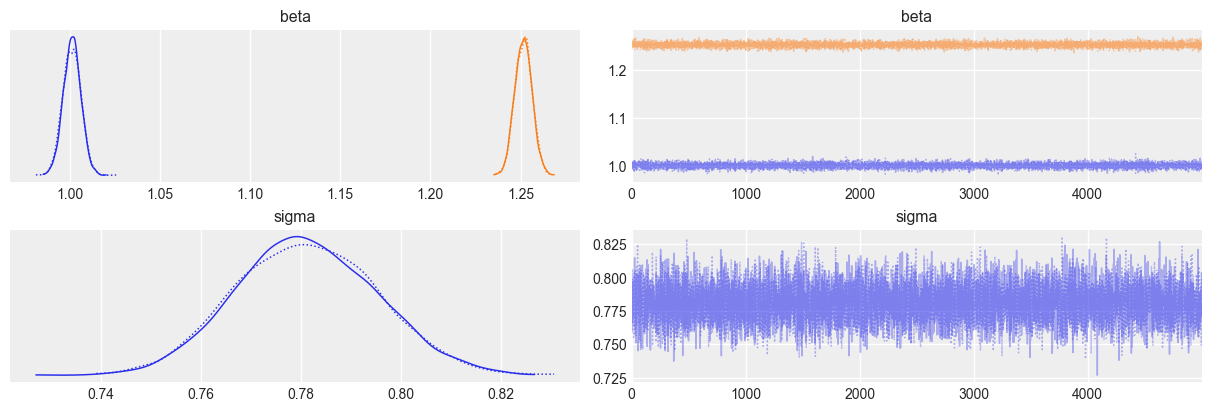

In [19]:
_ = az.plot_trace(inference)

TODO

In [21]:
az.summary(inference, round_to=4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.0010,0.0049,0.9918,1.0103,0.0000,0.0000,12949.6389,7445.9224,1.0013
beta[1],1.2516,0.0047,1.2425,1.2602,0.0000,0.0000,13561.4215,7174.6044,1.0001
sigma[0],0.7811,0.0140,0.7543,0.8065,0.0001,0.0001,12459.7430,6825.0304,1.0005


### Posterior Predictive Plot

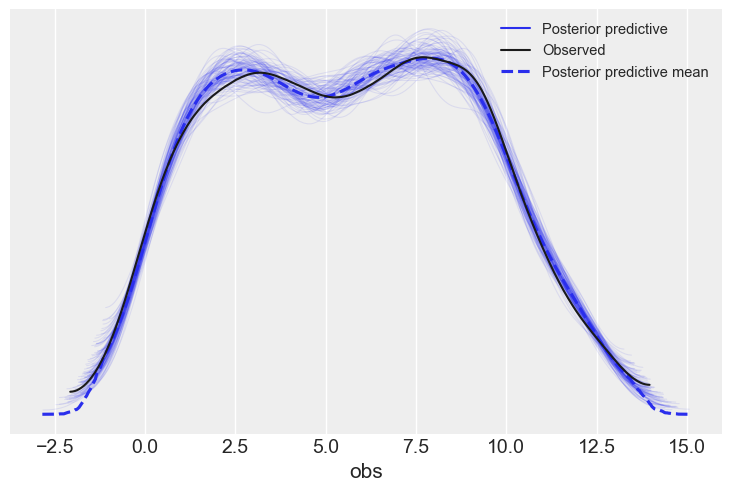

In [23]:
with model:
    posterior_pred_data = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(
            inference.posterior, samples=100
        )
    )

_ = az.plot_ppc(posterior_pred_data, alpha=0.1)

## Test Model

mean abs. pct. error = 15.71%


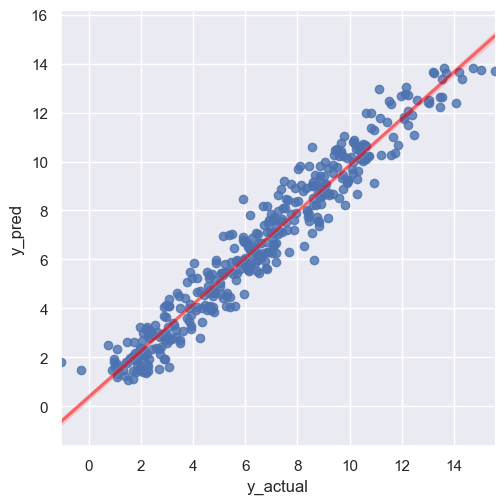

In [15]:
with model:
    pm.set_data({
        "y": test["y"],
        "x": test["x"],
        "category": test["category"]
    })
    posterior_pred = pm.sample_posterior_predictive(
        inference.posterior, samples=100
    )
    predictions = np.mean(posterior_pred["obs"], axis=0)

mape = mean_absolute_percentage_error(test["y"], predictions)
print(f"mean abs. pct. error = {mape:.2%}")
    
prediction_data = pd.DataFrame({"y_pred": predictions, "y_actual": test["y"]})
_ = sns.lmplot(
    y="y_pred",
    x="y_actual",
    data=prediction_data,
    line_kws={"color": "red", "alpha": 0.5}
)

## Persist Model

In [16]:
inference.to_netcdf("model_inference.nc")

'model_inference.nc'

In [17]:
joblib.dump(model, "model_definition.joblib")

['model_definition.joblib']

## Re-Load and Test

In [20]:
inference_test = az.from_netcdf("model_inference.nc")
model_test = joblib.load("model_definition.joblib")

In [21]:
with model_test:
    pm.set_data({
        "y": [0],
        "x": [10],
        "category": [0]
    })
    posterior_pred = pm.sample_posterior_predictive(
        inference_test.posterior, samples=100
    )
    prediction = np.mean(posterior_pred["obs"], axis=0)[0]
    print(f"y_pred = {prediction:.2f}")

y_pred = 10.82
